In [1]:
import sys
sys.path.append('/mnt/antares_raid/home/oliver/nideep')
sys.path.append('/mnt/antares_raid/home/oliver/Scripts/autoencoder')
import os
from TransformMNIST import MNISTtransformer
import subprocess
import sys
import caffe
import matplotlib
import numpy as np
import lmdb
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
import math
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.inference import infer_to_h5_fixed_dims, infer_to_lmdb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase
%matplotlib inline

/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [ ]:
def set_up_dir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [ ]:
src_lmdb_dir = '/mnt/antares_raid/home/oliver/adhara/src/caffe/examples/mnist/'
home_dir = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/'
set_up_dir(home_dir)
dst_lmdb_dir = home_dir + 'MNIST_lmdb/'
set_up_dir(dst_lmdb_dir)
N_ims = [60000, 10000]
angles = range(-90,90+1,15)
batch_size = 1000.
set_strings = ['_TRAIN_', '_TEST_']
dir_strings = ['_train_', '_test_']

if False:
    # Create the lmdb database
    for set_str, dir_str, N_im in zip(set_strings, dir_strings,N_ims):
        mnisttransform = MNISTtransformer(src_lmdb_dir, home_dir, dst_lmdb_dir, N_im, batch_size, set_str, dir_str, angles)
        mnisttransform.run()

In [ ]:
# Train autoencoder weights
#p = subprocess.Popen(["screen"])
#p = subprocess.Popen(["/mnt/antares_raid/home/oliver/adhara/src/caffe/build/tools/caffe", "train", "-solver", "/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/autoencoder_net_solver.prototxt"])

#/mnt/antares_raid/home/oliver/adhara/src/caffe/build/tools/caffe train -solver /mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/autoencoder_net_solver.prototxt 

In [ ]:

# Check weights

proto = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/deploy_autoencoder_net.prototxt'
model = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/snapshots/_iter_156000.caffemodel'
lmdb_path = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/MNIST_lmdb/MNIST_TEST_10000_rot_lmdb/shuffled/'

proto = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP/deploy_autoencoder_with_MLP_net.prototxt'
model = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP/snapshots_with_MLP/_iter_780000.caffemodel'
lmdb_path = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/MNIST_lmdb/MNIST_TEST_10000_rot_lmdb/shuffled/'

net = caffe.Net(proto, model, caffe.TEST)


count = 0
correct = 0
matrix = defaultdict(int) # (real,pred) -> int
labels_set = set()

net = caffe.Net(proto, model, caffe.TEST)
caffe.set_mode_cpu()
lmdb_env = lmdb.open(lmdb_path)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
for key, value in lmdb_cursor:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(value)
    label = int(datum.label)
    image = caffe.io.datum_to_array(datum)
    image = image.astype(np.uint8)
    
    out = net.forward_all(data=np.asarray([image]))
    plabel = int(out['score'][0].argmax(axis=0))

    count = count + 1
    iscorrect = label == plabel
    correct = correct + (1 if iscorrect else 0)
    matrix[(label, plabel)] += 1
    labels_set.update([label, plabel])

    #if not iscorrect:
    #    print("\rError: key=%s, expected %i but predicted %i" \
    #            % (key, label, plabel))

    #sys.stdout.write("\rAccuracy: %.1f%%" % (100.*correct/count))
    #sys.stdout.flush()
    
    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    plt.imshow(image.reshape(28, 28).T, cmap='gray'); plt.axis('off')
    plt.colorbar()
    plt.title('Input')
    plt.subplot(1,2,2)
    plt.imshow(np.array([sigmoid(a) for a  in out['decode1'].squeeze()]).reshape(28, 28).T, cmap='gray'); plt.axis('off')
    plt.title('decode1 output')
    plt.colorbar()
    plt.show()

    if count == 5:
        break
#print(str(correct) + " out of " + str(count) + " were classified correctly")

print ""
print "Confusion matrix:"
print "(r , p) | count"
for l in labels_set:
    for pl in labels_set:
        print "(%i , %i) | %i" % (l, pl, matrix[(l,pl)])

In [ ]:
#Train Autoencoder + MLP
model = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/snapshots_28_07/_iter_702000.caffemodel'

#p = subprocess.Popen(["screen"])
#p = subprocess.Popen(["/mnt/antares_raid/home/oliver/adhara/src/caffe/build/tools/caffe", "train", 
#"-solver", "/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP/autoencoder_with_MLP_solver.prototxt","-weights", "/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/snapshots_28_07/_iter_702000.caffemodel"])


In [ ]:
# Use Youssef Script to save results to hdf5
proto = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP/autoencoder_with_MLP_net.prototxt'
model = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP/snapshots_with_MLP/_iter_780000.caffemodel'
lmdb_path = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/MNIST_lmdb/MNIST_TRAIN_60000_rot_lmdb/shuffled/'

net = caffe.Net(proto, model, caffe.TRAIN)
#print(list(net._layer_names))

keys = ['label', 'score', 'data']
dst_fpath =  "/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP/results/res_train.hdf5"
n = 780
infer_to_h5_fixed_dims(net, keys, n, dst_fpath, preserve_batch=False)

# Use encoding weights to train an MLP

dst_prefix =  '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP/results/%s'
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))



In [ ]:
import h5py
dst_fpath =  "/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP/results/res_train.hdf5"
f = h5py.File(dst_fpath, "r")
pred = [np.argmax(p) for p in f['score']]
true = list(f['label']) 
print(classification_report(true,pred))
conf_mat = confusion_matrix(true,pred)

In [ ]:
plt.imshow((conf_mat/780000.), interpolation='none')
plt.colorbar()
plt.show()

/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP_logfile/log/20160801.log


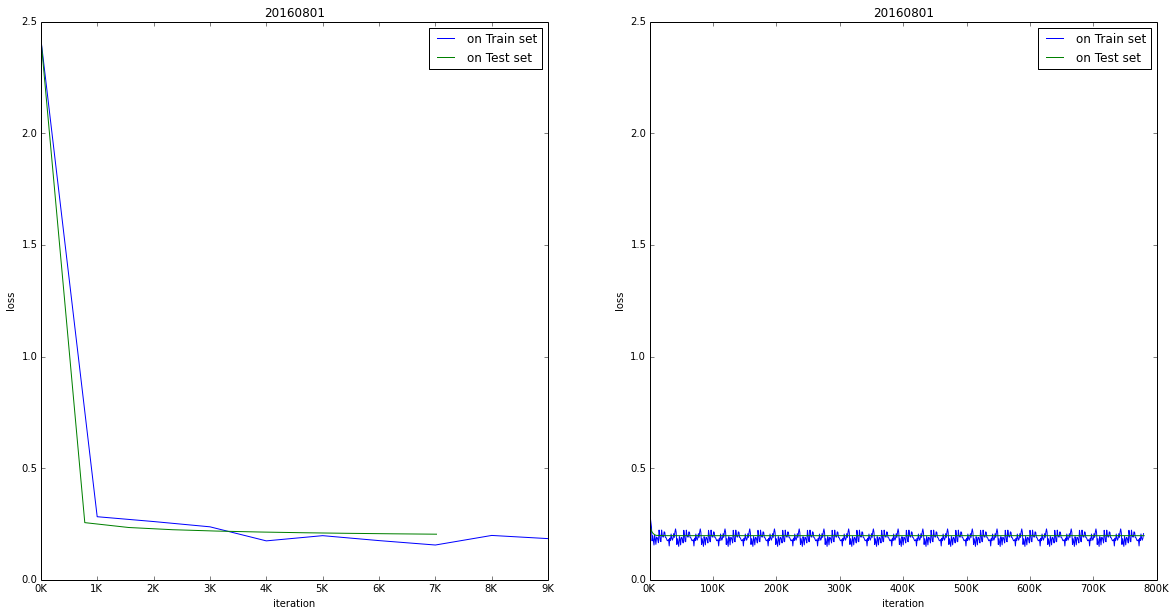

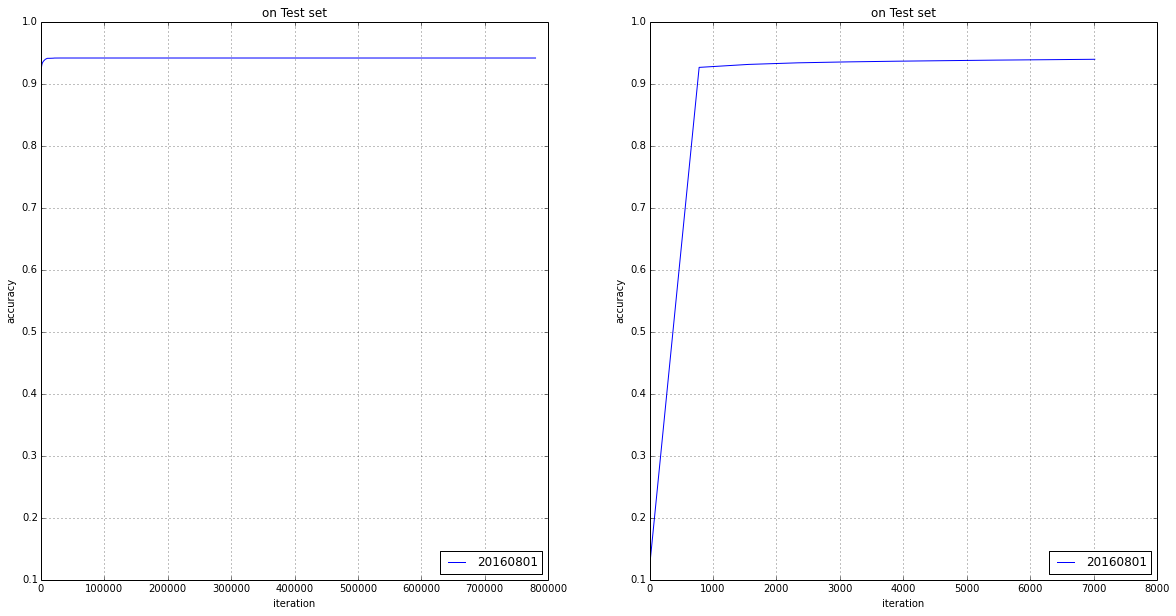

In [12]:
log_path = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder_with_MLP_logfile/log/20160801.log'

e = LearningCurve(log_path)
print(e.path_log)

e.parse()
plt.figure(figsize=(20,10))
for phase in [Phase.TRAIN, Phase.TEST]:
    num_iter = e.list('NumIters', phase)
    loss = e.list('loss', phase)
    plt.subplot(1,2,1)
    plt.plot(num_iter[:10], loss[:10], label='on %s set' % (phase,))
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('loss')
    plt.title(e.name())
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(num_iter, loss, label='on %s set' % (phase,))
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('loss')
    plt.title(e.name())
    plt.legend()
    
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
num_iter = e.list('NumIters', phase)
acc = e.list('accuracy', phase)
plt.plot(num_iter, acc, label=e.name())
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title("on %s set" % (phase,))
plt.legend(loc='lower right')
plt.grid()

plt.subplot(1,2,2)
plt.plot(num_iter[:10], acc[:10], label=e.name())
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title("on %s set" % (phase,))
plt.legend(loc='lower right')
plt.grid()